In [2]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import poppy
import threading as th
import time 
from IPython.display import clear_output
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi.scoobi as scoobi
import scoobi.utils as utils
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3

import scoobpsf.psds as psds
import lina

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

wavelength = 633e-9


INFO:purepyindi2.transports:Connected to localhost:7624


In [27]:
reload(scoobi)
xc, yc = (4263, 2920)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [3]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', locam_channel='nsvcam', dm_channel='dm00disp06')

# Aquire LLOWFSC image

In [3]:
reload(scoobi)
scoobi.move_block_in(client0)

In [7]:
reload(scoobi)
scoobi.move_block_out(client0)

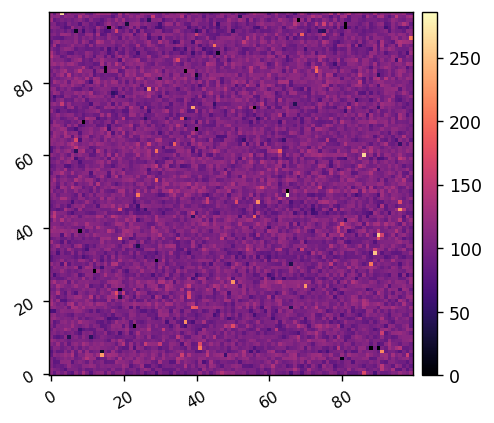

In [4]:
I.Nframes = 50
I.subtract_dark_locam = False
I.return_ni_locam = False
dark_frame = I.snap_locam()
imshow1(dark_frame)

I.df_locam = copy.copy(dark_frame)

INFO:utils:Got semaphore index 1.


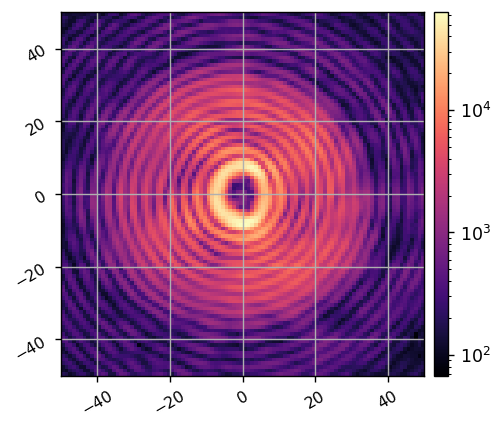

In [4]:
I.x_shift_locam = 7
I.y_shift_locam = 3
I.Nframes_locam = 5

I.att_ref = 0
I.texp_locam_ref = 0.0001
I.gain_locam_ref = 120

I.att = 0
I.texp_locam = 0.0001
I.gain_locam = 120
I.return_ni_locam = True
# I.subtract_dark_locam = True

ref_im = I.stack_locam()
imshow1(ref_im, grid=True, pxscl=1, lognorm=True)

# Create the time series of WFE to inject with the DM modulator app

In [7]:
initial_jitter = 35*u.mas
dm_pupil_diam = 9.1*u.mm
total_pupil_diam = 2.4*u.m
tt_pv_to_rms = 1/4

# Recreating Chris's tip/tilt conversion from mas to nm
# initial_jitter = 96.6*u.mas
# tt_pv_to_rms = 1/4
# total_pupil_diam = 2*u.m

mag = total_pupil_diam.to_value(u.m)/dm_pupil_diam.to_value(u.m)

tt_at_dm_pupil = mag * initial_jitter
print(tt_at_dm_pupil)

tt_at_dm_pupil_pv = np.tan(tt_at_dm_pupil).value * dm_pupil_diam
print(tt_at_dm_pupil_pv.to(u.nm))

tt_at_dm_pupil_rms = tt_at_dm_pupil_pv * tt_pv_to_rms
print(tt_at_dm_pupil_rms.to(u.nm))


9230.76923076923 mas
407.2434924038784 nm
101.8108731009696 nm


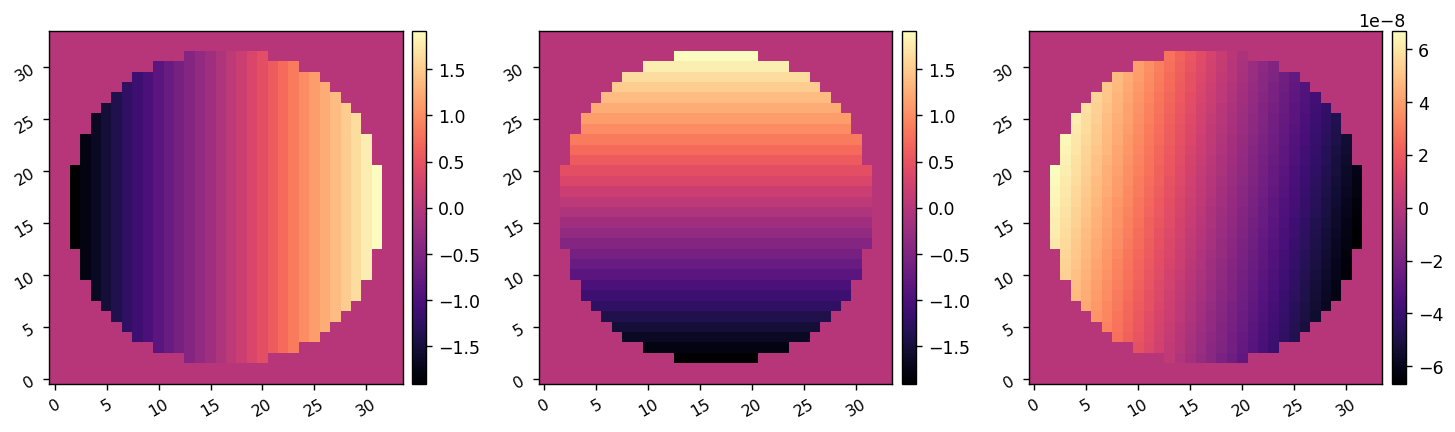

In [9]:
wfe_modes_rms = np.array([tt_at_dm_pupil_rms.to_value(u.m)/2]*2)
knee_freqs = np.array([0.05]*2) * u.Hz
fmax = 100*u.Hz

# wfe_modes_rms = np.array([20e-9]*2 + [5e-9]*3 + [2.5e-9]*6) / 2
# wfe_modes_rms = np.array([10e-9]*2 + [5e-9]*3 + [2.5e-9]*4 + [1e-9]*11)

N_wfe_modes = len(wfe_modes_rms)
wfe_modes = lina.utils.create_zernike_modes(I.dm_pupil_mask, nmodes=N_wfe_modes, remove_modes=1)

freqs, delF, times = psds.generate_freqs(Nf=2**18+1, f_max=fmax)

wfe_time_series = xp.zeros((N_wfe_modes+1, len(times)))
wfe_time_series[0] = xp.array(times.to_value(u.s))

slope = 4
for i in range(N_wfe_modes):
    f_knee = knee_freqs[i]
    psd = psds.kneePSD(freqs, 1, f_knee, slope)
    coeff = psds.generate_time_series(psd, fmax, rms=1, seed=12345+i)
    wfe_time_series[i+1] = wfe_modes_rms[i] * xp.array(coeff)

i = 0
lo_wfe = wfe_modes.reshape(N_wfe_modes, I.Nact**2).T.dot(wfe_time_series[1:,i]).reshape(I.Nact, I.Nact)
imshow3(wfe_modes[0], wfe_modes[1], lo_wfe)

In [12]:
times[-1]

<Quantity 2621.435 s>

In [7]:
N = len(wfe_time_series[0])
wfe_time_series = xp.array(wfe_time_series)
wfe_cube = xp.zeros((N, I.Nact, I.Nact))
for i in range(N):
    wfe_cube[i] = wfe_modes.reshape(N_wfe_modes, I.Nact**2).T.dot(wfe_time_series[1:,i]).reshape(I.Nact, I.Nact)
    if i//N==1/4 or i//N==1/2 or i//N==3/4:
        print(i)

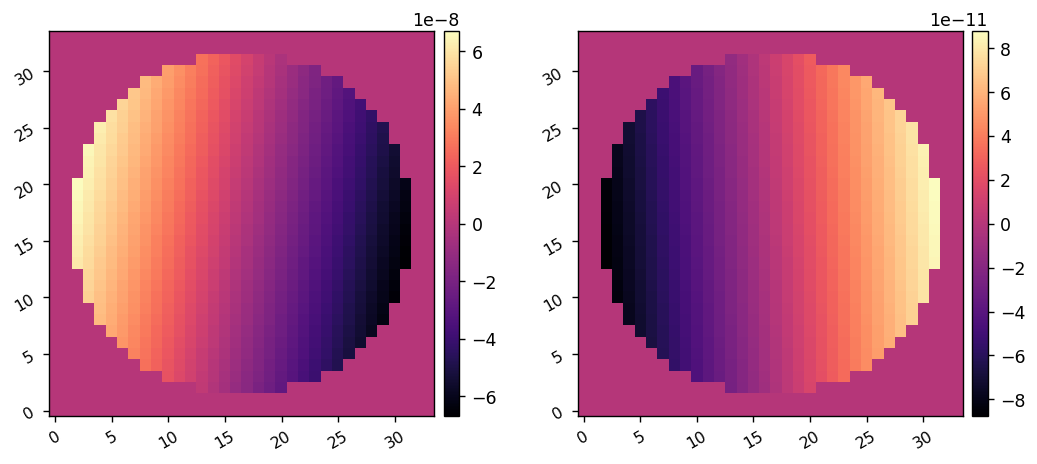

In [8]:
i = 2100
i = N-2
imshow2(wfe_cube[i], wfe_cube[i+1] - wfe_cube[i])

In [16]:
utils.save_fits('../data/wfe_time_series.fits', wfe_cube*1e6)

Saved data to:  ../data/wfe_time_series.fits


ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Failed to connect to localhost:7624 [[Errno 111] Connection refused]
INFO:purepyindi2.transports:Retrying in 2 sec...
ERROR:purepyindi2.transports:Failed to connect to localhost:7624 [[Errno 111] Connection refused]
INFO:purepyindi2.transports:Retrying in 2 sec...
ERROR:purepyindi2.transports:Failed to connect to localhost:7624 [[Errno 111] Connection refused]
INFO:purepyindi2.transports:Retrying in 2 sec...
ERROR:purepyindi2.transports:Failed to connect to localhost:7624 [[Errno 111] Connection refused]
INFO:purepyindi2.transports:Retrying in 2 sec...
ERROR:purepyindi2.transports:Failed to connect to localhost:7624 [[Errno 111] Connection refused]
INFO:purepyindi2.transports:Retrying in 2

In [12]:
restart_clients()

INFO:purepyindi2.transports:Connected to localhost:7624


In [10]:
reload(scoobi)
scoobi.set_kilo_mod_amp(1, client0)
scoobi.set_kilo_mod_rate(2*fmax.to_value(u.Hz), client0) 
# We need to set the modulation rate to twice the maximum frequency sampled by the PSD

In [11]:
reload(scoobi)
scoobi.start_kilo_mod(client0)

In [12]:
reload(scoobi)
scoobi.stop_kilo_mod(client0)

# Perform LLOWFSC calibration

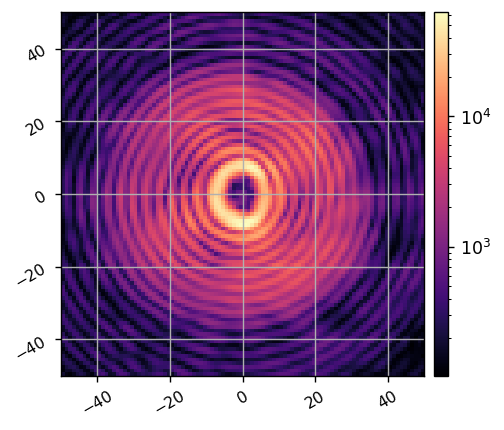

In [13]:
I.x_shift_locam = 7
I.y_shift_locam = 3
I.Nframes_locam = 25

I.att_ref = 0
I.texp_locam_ref = 0.0001
I.gain_locam_ref = 120

I.att = 0
I.texp_locam = 0.0001
I.gain_locam = 120
I.return_ni_locam = True
I.subtract_dark_locam = True

ref_im = I.stack_locam()
imshow1(ref_im, grid=True, pxscl=1, lognorm=True)

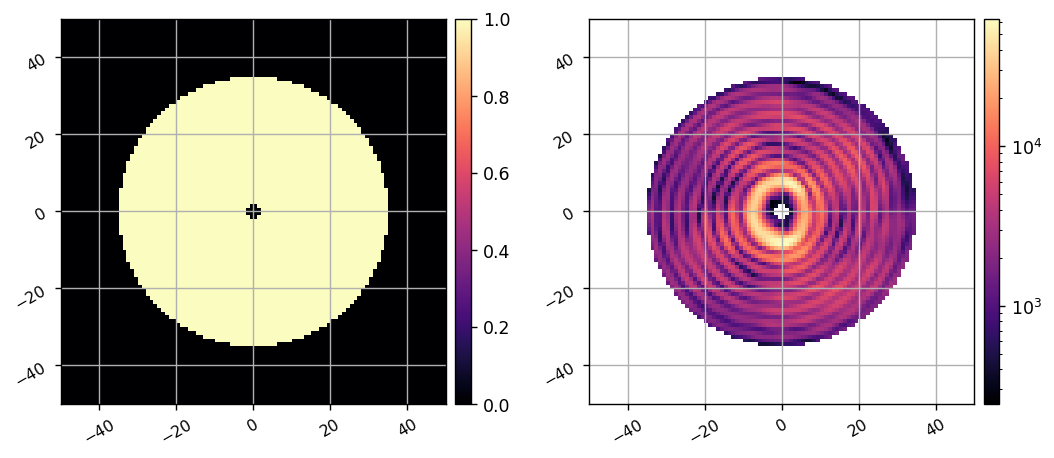

In [14]:
irad = 2
orad = 35
control_mask = ensure_np_array(lina.utils.create_annular_focal_plane_mask(I.nlocam, 1, irad, orad, edge=None))

imshow2(control_mask, ref_im * control_mask, grid=True, pxscl=1, lognorm2=True)

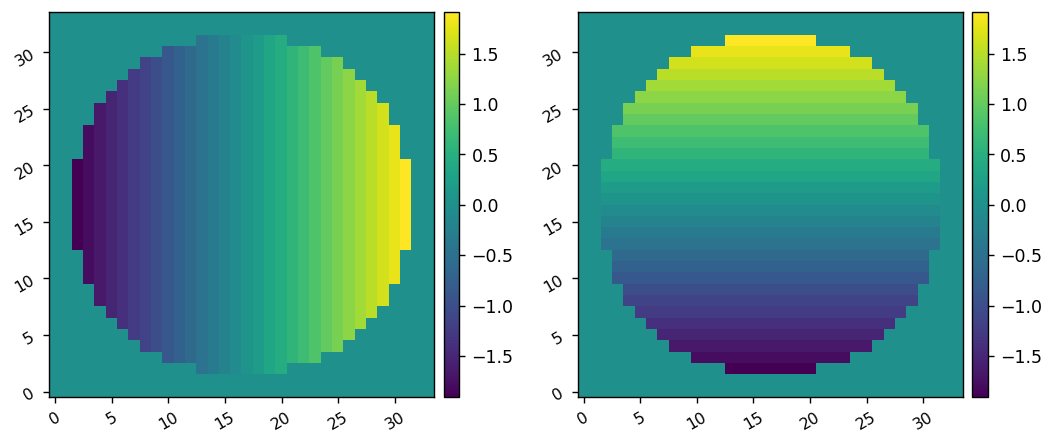

In [15]:
Nmodes = 2
dm_zernikes = lina.utils.create_zernike_modes(I.dm_pupil_mask, nmodes=Nmodes, remove_modes=1)
imshow2(dm_zernikes[0], dm_zernikes[1], cmap1='viridis', cmap2='viridis')

calib_modes = copy.copy(ensure_np_array(dm_zernikes))
modal_matrix = calib_modes.reshape(Nmodes, I.Nact**2).T

0.001


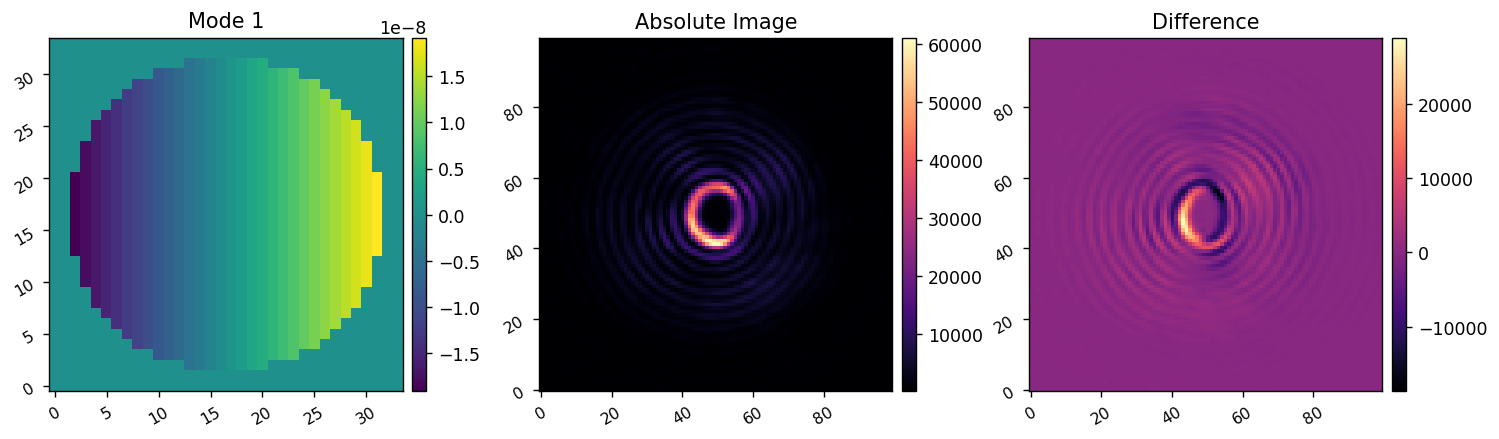

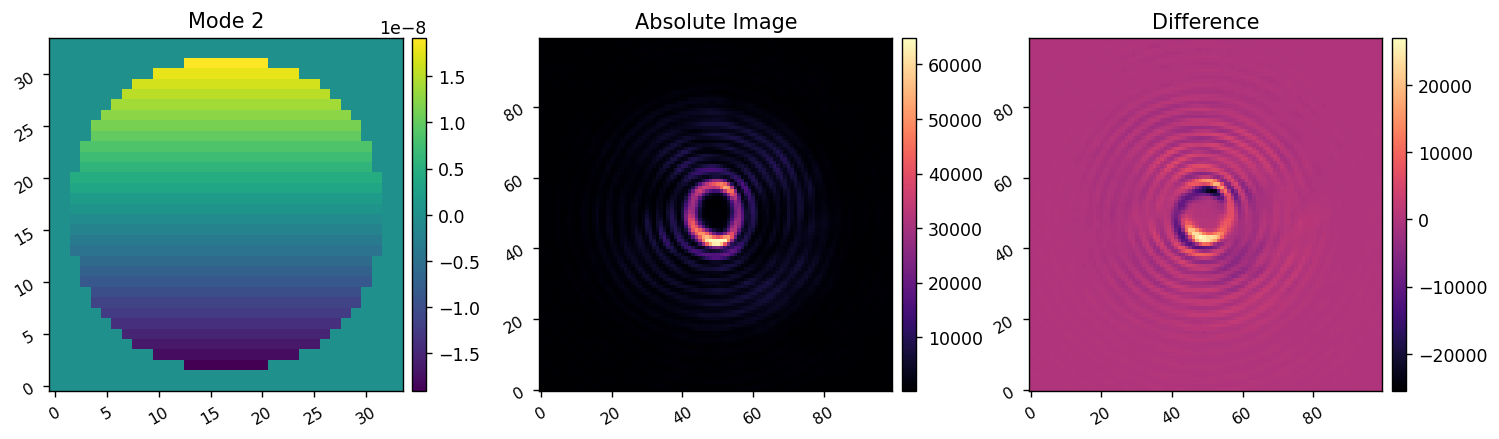

In [16]:
reload(lina.llowfsc)

I.reset_dm()
I.Nframes_locam = 10
I.return_ni_locam = True
I.dm_delay = I.texp_locam * 10
print(I.dm_delay)

response_matrix = lina.llowfsc.calibrate(I, calib_modes, control_mask, amps=10e-9, plot=True)

In [17]:
control_matrix = ensure_np_array(lina.utils.TikhonovInverse(xp.array(response_matrix), 0))

# Define the function and process to run LLOWFSC at the desired frequency

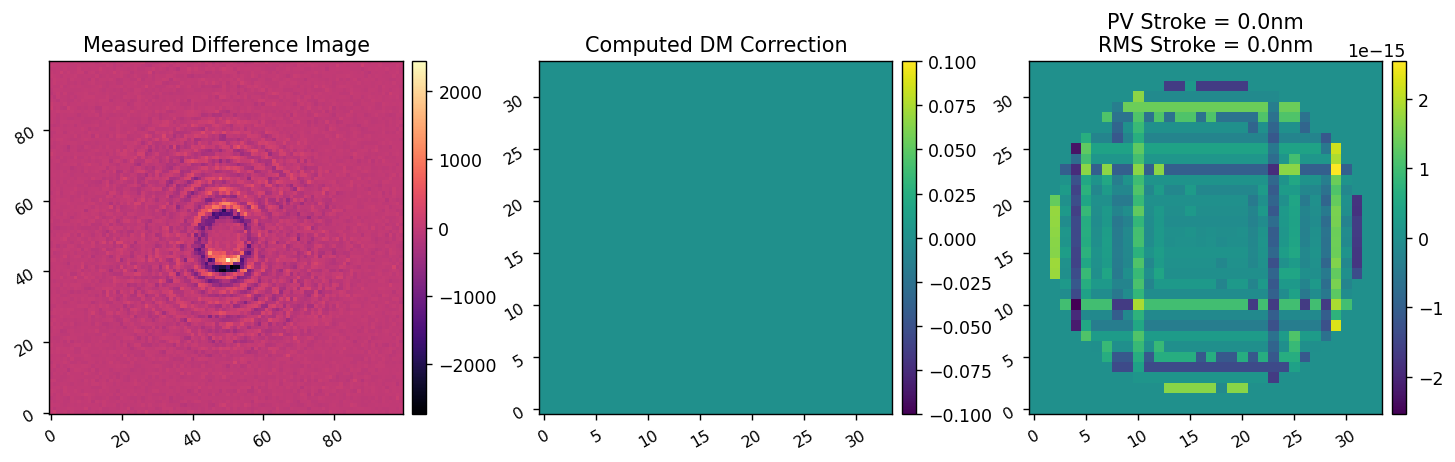

In [18]:
reload(lina.llowfsc)
lina.llowfsc.run_iteration(I, ref_im, control_matrix, modal_matrix, control_mask, thresh=[2e-9, 2e-9], plot=True)
I.zero_dm()

In [26]:
reload(scoobi)
reload(lina.llowfsc)
reload(lina.utils)

llowfsc_freq = 50
I.return_ni_locam = True
I.dm_delay = 1*I.texp_locam

args = [I, ref_im, control_matrix, modal_matrix, control_mask]
kwargs = {
    'gain':[0.25]*2,
    # 'thresh':[2e-9, 2e-9],
}

llowfsc_process = lina.utils.Process(1/llowfsc_freq, 
                                       lina.llowfsc.run_iteration, 
                                       args, # the args
                                       kwargs, # the kwargs
                                       )


scoobi.set_kilo_mod_amp(1, client0)
scoobi.set_kilo_mod_rate(2*fmax.to_value(u.Hz), client0)


In [27]:
reload(scoobi)
scoobi.start_kilo_mod(client0, delay=0.1)

llowfsc_process.start()

In [29]:
reload(scoobi)
scoobi.stop_kilo_mod(client0, delay=0.1)

llowfsc_process.cancel()
I.zero_dm()

In [170]:
llowfsc_process.cancel()
I.zero_dm()